In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/PROYECTO FINAL UTN/data/raw/telco.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA

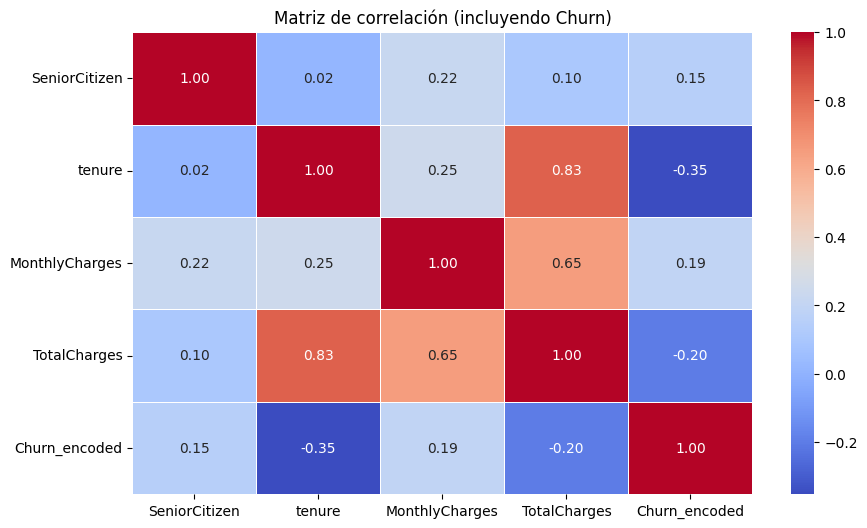

In [6]:
# Matriz de correlación
numerical_df = df.select_dtypes(include=np.number).copy()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
numerical_df['Churn_encoded'] = le.fit_transform(df['Churn'])

correlation_matrix = numerical_df.corr()

# Visualización de la matriz de correlación con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",
linewidths=0.5)
plt.title("Matriz de correlación (incluyendo Churn)")
plt.show()

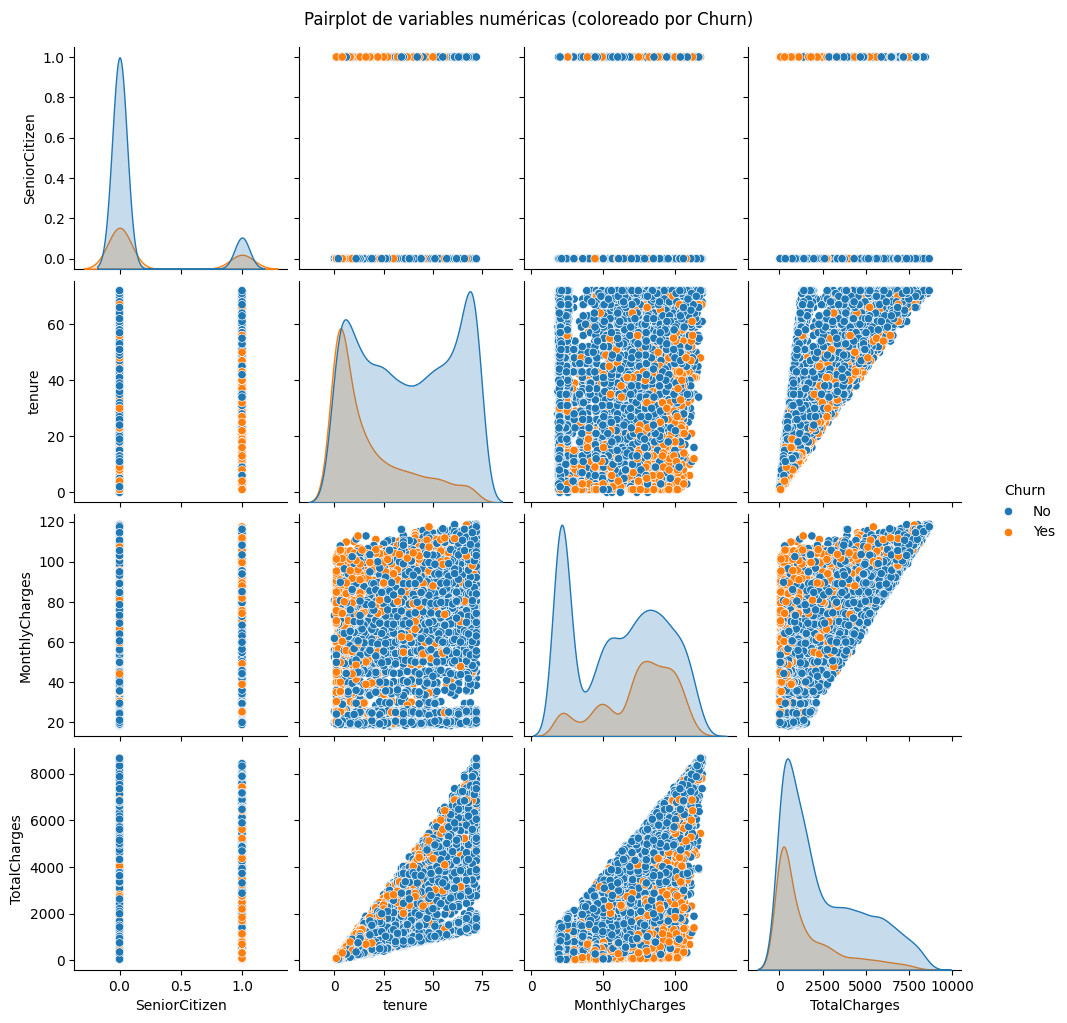

In [7]:
# Pairplot para visualizar relaciones entre múltiples variables
sns.pairplot(df, diag_kind="kde", hue='Churn')
plt.suptitle("Pairplot de variables numéricas (coloreado por Churn)", y=1.02)
plt.show()

Podemos observar que la mayor cantidad de churn se concentran en los primeros meses de ternure (entre 0 y 25) y de ahí van bajando gradualmente, es decir, mientras más meses esten pagando el servicio menor es la probabilidad de abandono, viendolo desde un punto de vista estratégico la empresa debería emplear estrategías para evitar el abandono prematuro para los clientes que se encuentran en los primeros 2 años de abono del servicio.

A su vez también se puede ver en el scatterplot de ternure en eje x y MonthlyCharges en eje y, que los casos de churn positivos se concentran en los primeros meses de ternure y MonthlyCharges altos.

Estas 2 variables son particularmente importantes porque como veremos más adelante el modelo de regresión logística (que fue el que mejor performó) va a decidir en base a estas 2 variables principalmente.

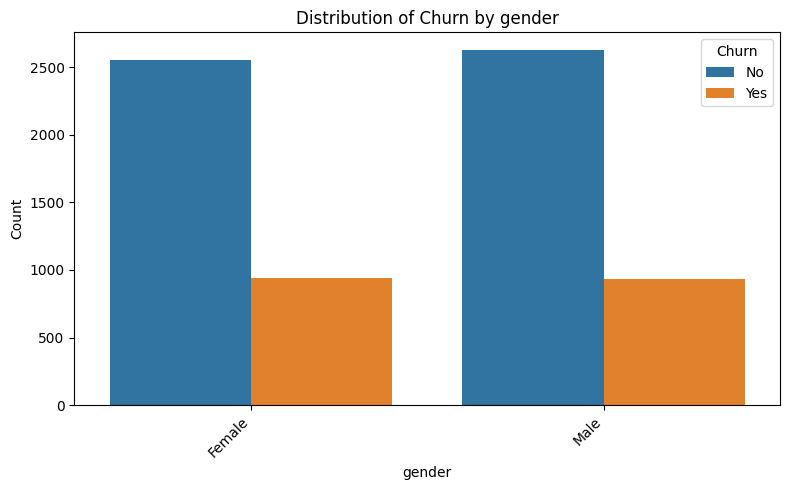

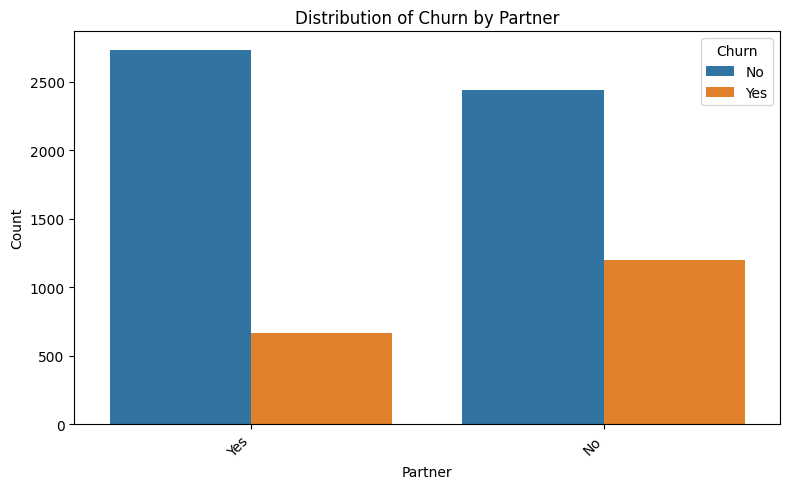

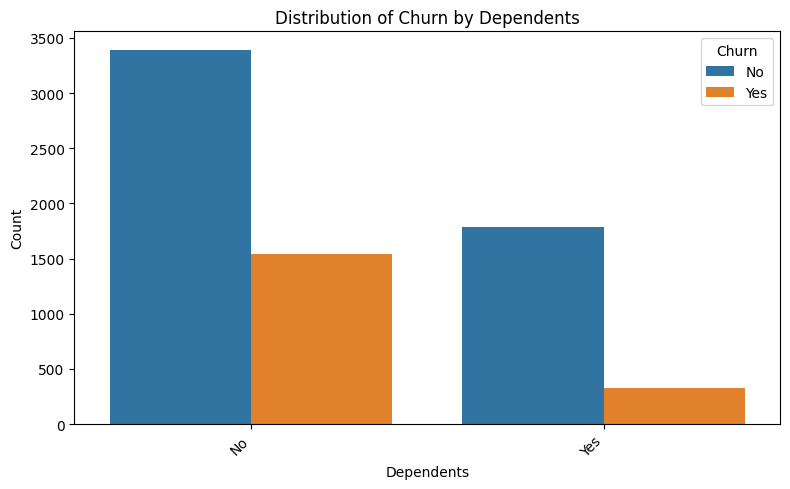

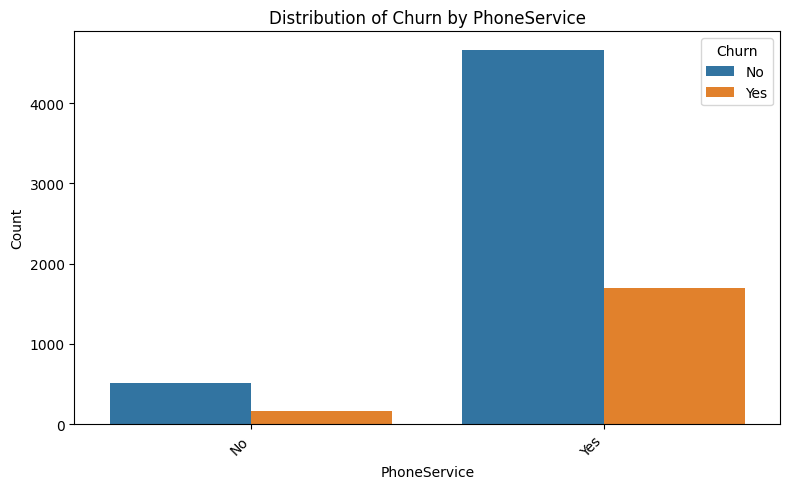

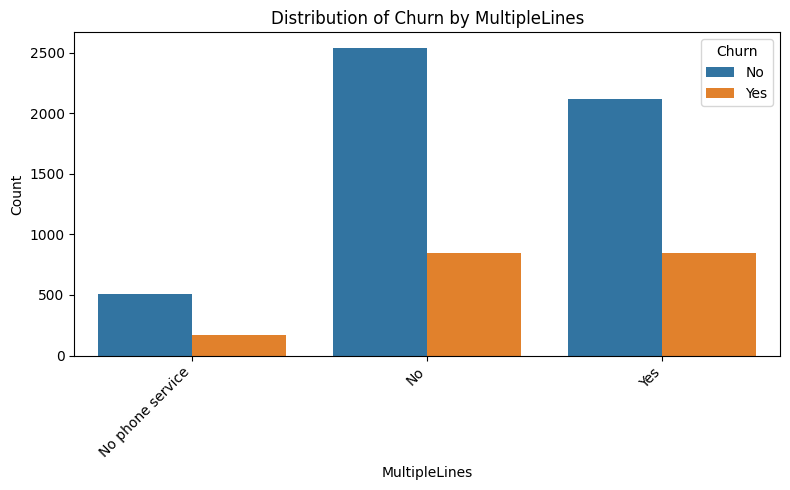

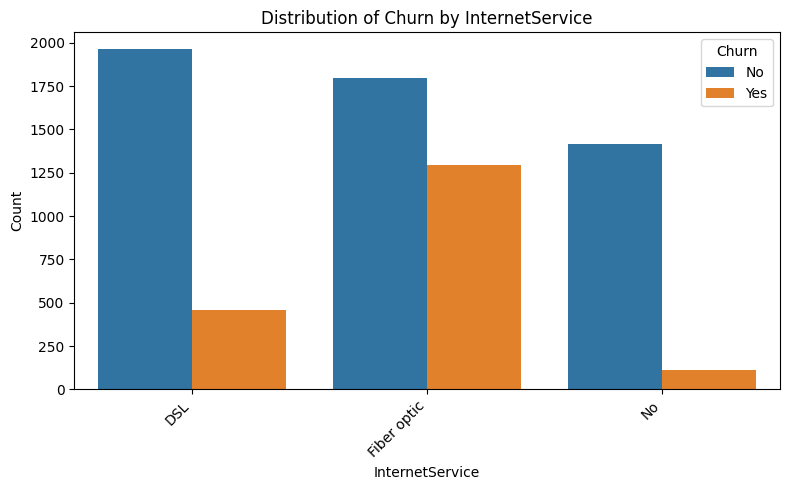

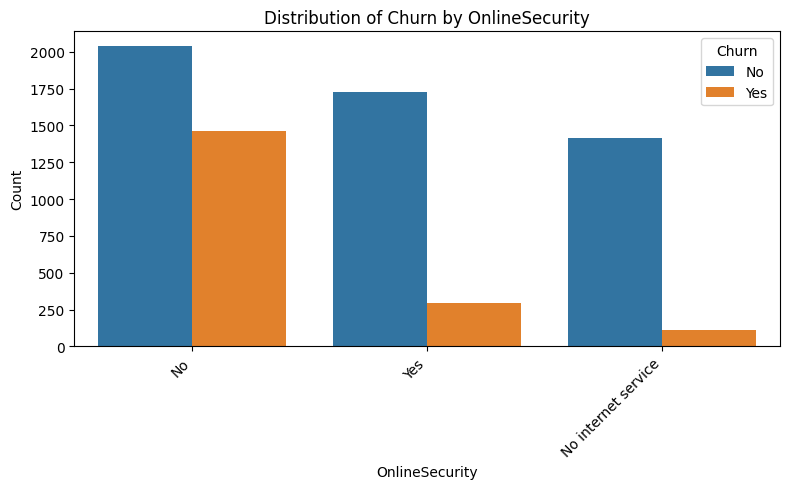

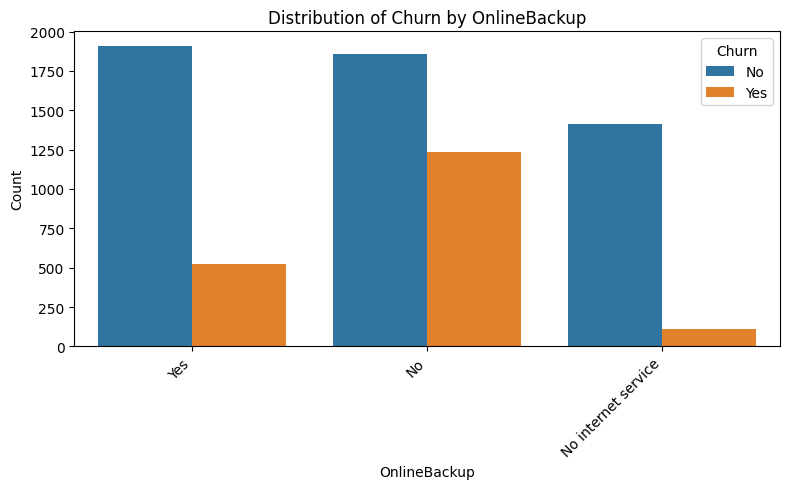

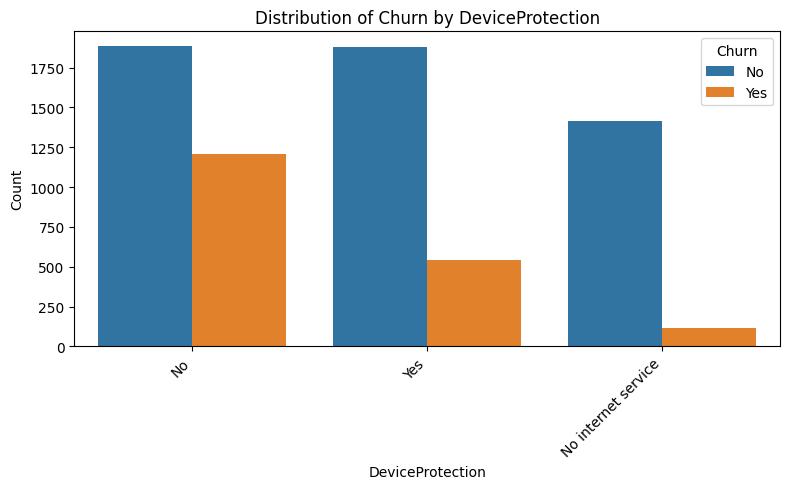

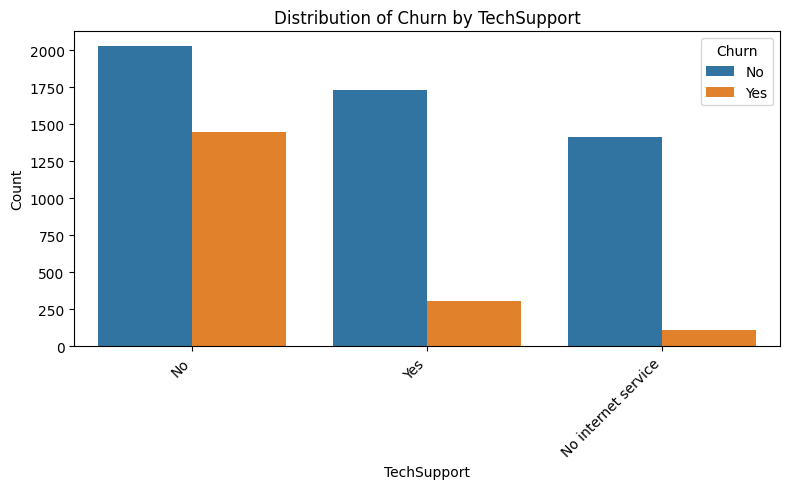

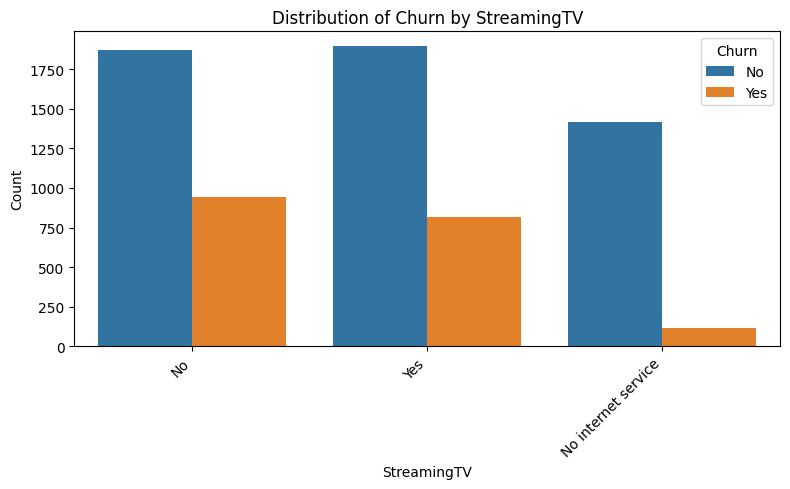

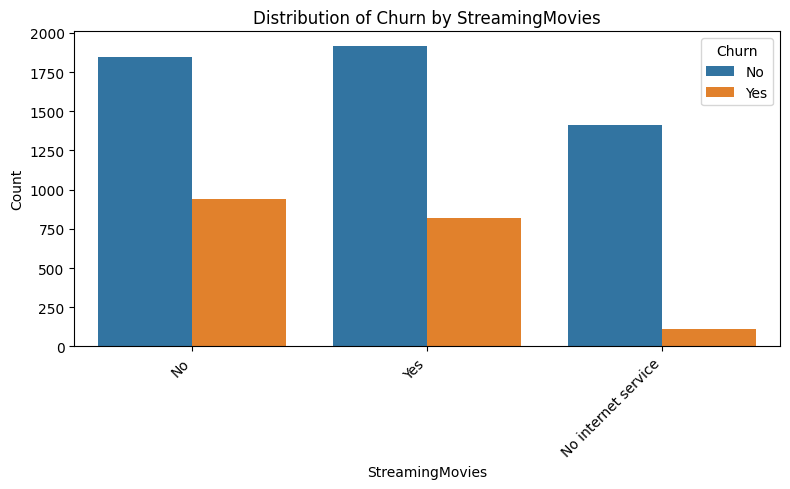

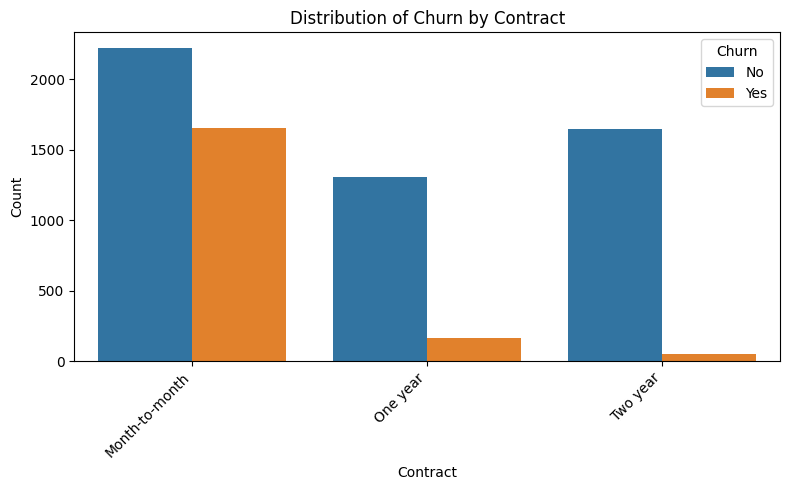

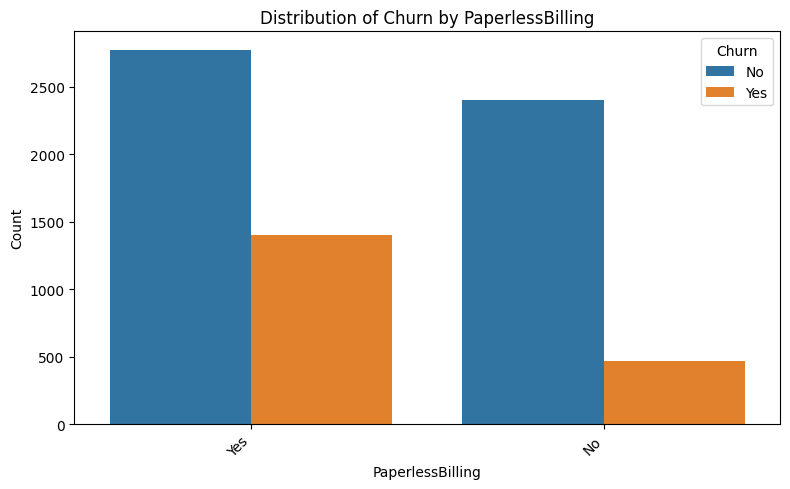

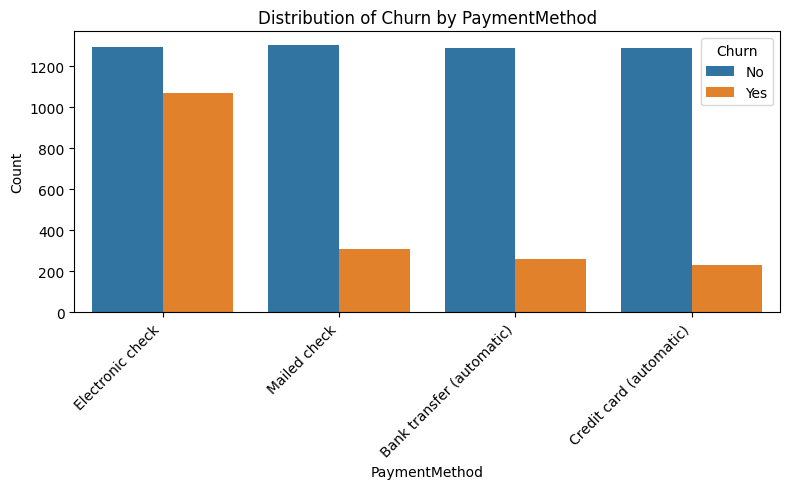

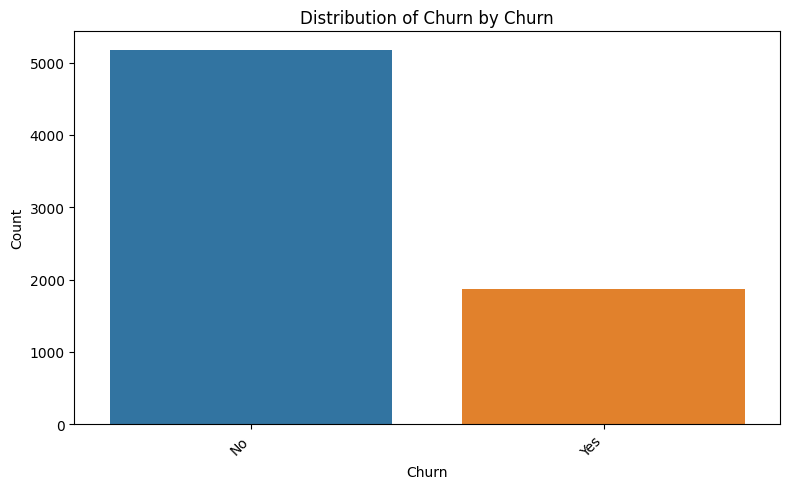

In [8]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('customerID')


for col in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Distribution of Churn by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [9]:
# Calcular porcentaje de churn por categoría
churn_percentages = {}

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'customerID' in categorical_features:
    categorical_features.remove('customerID')

for col in categorical_features:
    churn_counts = df.groupby([col, 'Churn']).size().unstack(fill_value=0)
    churn_counts['Total'] = churn_counts['No'] + churn_counts['Yes']
    churn_counts['Churn_Percentage'] = (churn_counts['Yes'] / churn_counts['Total']).fillna(0) * 100

    for index, row in churn_counts.iterrows():
        if not (col != 'InternetService' and 'No internet service' in str(index)):
             churn_percentages[f"{col}_{index}"] = row['Churn_Percentage']


sorted_churn_percentages = sorted(churn_percentages.items(), key=lambda item: item[1], reverse=True)

print("10 categorías que mayor porcentaje de churn tienen:")
for category, percentage in sorted_churn_percentages[:10]:
    print(f"{category}: {percentage:.2f}%")

print("\n10 categorías que menor porcentaje de churn tienen:")
sorted_churn_percentages_lowest = sorted(churn_percentages.items(), key=lambda item: item[1])
for category, percentage in sorted_churn_percentages_lowest[:10]:
    print(f"{category}: {percentage:.2f}%")

10 categorías que mayor porcentaje de churn tienen:
Churn_Yes: 100.00%
PaymentMethod_Electronic check: 45.29%
Contract_Month-to-month: 42.71%
InternetService_Fiber optic: 41.89%
OnlineSecurity_No: 41.77%
TechSupport_No: 41.64%
OnlineBackup_No: 39.93%
DeviceProtection_No: 39.13%
StreamingMovies_No: 33.68%
PaperlessBilling_Yes: 33.57%

10 categorías que menor porcentaje de churn tienen:
Churn_No: 0.00%
Contract_Two year: 2.83%
InternetService_No: 7.40%
Contract_One year: 11.27%
OnlineSecurity_Yes: 14.61%
TechSupport_Yes: 15.17%
PaymentMethod_Credit card (automatic): 15.24%
Dependents_Yes: 15.45%
PaperlessBilling_No: 16.33%
PaymentMethod_Bank transfer (automatic): 16.71%
